In [149]:
import os
#import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from util import Timer, Event, normalize_image, animate, load_events, plot_3d, event_slice
from time import time
from scipy import fftpack,signal

plt.close('all')

In [150]:
def gaussian(t, mu, sigma):
    return np.exp( -0.5 * ((t-mu)/sigma)**2 )

In [192]:
sf = 0.1 # scale factor to compress in time (detect faster motions)

mono_wm1=1.95
mono_wm2=0.23
mono_mium1=0.55*sf
mono_mium2=0.55*sf
mono_sigmam1=0.10*sf
mono_sigmam2=0.16*sf

bi_wm1=0.83
bi_wm2=-0.34
bi_mium1=0.44*sf
bi_mium2=0.63*sf
bi_sigmam1=0.12*sf
bi_sigmam2=0.21*sf
x0=0
y0=0
xi0=math.pi*2

f0x = 0.057 # units: cycles/pix ?
f0y = f0x

In [193]:
with Timer('Loading'):
    # n_events = 1e4
    path_to_events = '../slider_far/events.txt'
    event_data = load_events(path_to_events)


Loading events...
width, height: 240, 180
Loaded 3.44M events
Loading: 7.53s


In [153]:
def gabor_filter_even(x,y,delta,theta,f0x,f0y):
    x_hat=np.cos(theta)*x+np.sin(theta)*y
    y_hat=-np.sin(theta)*x+np.cos(theta)*y
    pi=math.pi
    Gabor_k=1./(2*pi*delta**2)*np.exp(-1./(2*delta**2)*((x_hat-x0)**2+(y_hat-y0)**2))*np.cos(xi0*(f0x*x_hat+f0y*y_hat))
    return Gabor_k

def gabor_filter_odd(x,y,delta,theta,f0x,f0y):
    x_hat=np.cos(theta)*x+np.sin(theta)*y
    y_hat=-np.sin(theta)*x+np.cos(theta)*y
    pi=math.pi
    Gabor_k=1./(2*pi*delta**2)*np.exp(-1./(2*delta**2)*((x_hat-x0)**2+(y_hat-y0)**2))*np.sin(xi0*(f0x*x_hat+f0y*y_hat))
    return Gabor_k


In [154]:
def filter_mono(t):
    value=mono_wm1*np.exp(-(t-mono_mium1)**2/(2*mono_sigmam1**2))+mono_wm2*np.exp(-(t-mono_mium2)**2/(2*mono_sigmam2**2))
    return value

def filter_bi(t):
    value=bi_wm1*np.exp(-(t-bi_mium1)**2/(2*bi_sigmam1**2))+bi_wm2*np.exp(-(t-bi_mium2)**2/(2*bi_sigmam2**2))
    return value


plotting...: 0.06s


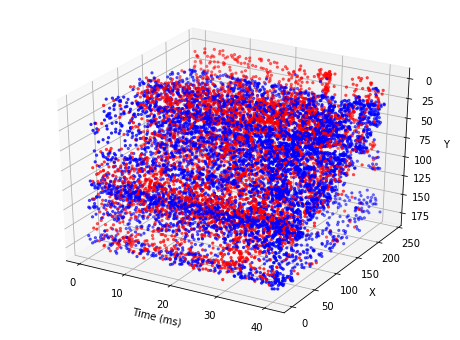

In [189]:
with Timer("plotting..."):
    plot_3d(event_data,len(event_data.event_list))

In [156]:
def integrator(event_data, delta,theta):
    print('Integrating, please wait...')
    events, height, width = event_data.event_list, event_data.height, event_data.width
    with Timer('Integrating  (simple)'):
        image_state = np.zeros((height, width), dtype=np.float32)
        # image_list = []
        for  e in events:
            image_state[e.y, e.x] = image_state[e.y, e.x] +\
                                    e.p*(filter_bi(e.t)*gabor_filter_even(e.x,e.y,delta,theta,f0x,f0y)+
                                    filter_mono(e.t)*gabor_filter_odd(e.x,e.y,delta,theta,f0x,f0y))
    plt.imshow(image_state, cmap=cm.coolwarm)
    return image_state

In [157]:
def conv_integrator(image,kernelSize):
     print('Convolution, please wait...')
     kerDimx=kernelSize
     kerDimy=kernelSize
     kernel=np.ones((kerDimy, kerDimx), dtype=np.float32)
     # print("kernel",kernel)
     with Timer('Convolution (simple)'):
         result = signal.convolve(image, kernel, mode = "same")
     return result

333.3333333333333


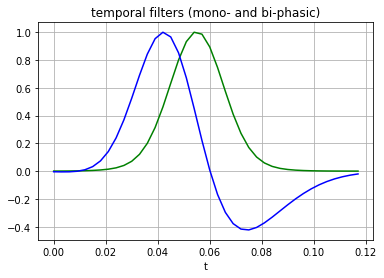

In [194]:
dt_res = 0.03*sf
ft_nyquist = 1. / dt_res  # Nyquist sampling frequency
print(ft_nyquist) # Hz

t = np.arange(0., 1.2*sf, dt_res)
Tmono = filter_mono(t)
Tbi = filter_bi(t)

fig2,ax1 = plt.subplots()
ax1.plot(t,Tmono/np.max(np.abs(Tmono)),'g-')
ax1.plot(t,Tbi/np.max(np.abs(Tbi)),'b-')
ax1.set_title("temporal filters (mono- and bi-phasic)")
ax1.set_xlabel('t')
plt.grid()
plt.show()

In [195]:
hksize = 11 # half of the kernel size
ksize = 2*hksize+1 # kernel size
x = np.linspace(-hksize,hksize,ksize)
print(x)
xv,yv = np.meshgrid(x,x)

dx = 1. # pixels
ft_nyquist = 1. / dx  # Nyquist sampling frequency in (x,y)-space, in cycles / pix
# So f0x and f0y cannot be larger than 0.5 cycles / pix

[-11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.
   3.   4.   5.   6.   7.   8.   9.  10.  11.]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f5d1bfdfeb8>,
 <matplotlib.image.AxesImage at 0x7f5d2dec6b00>)

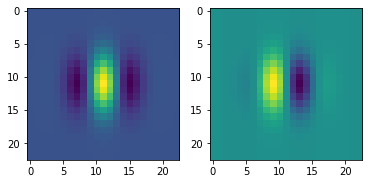

In [196]:
sigma=3
f0x = -0.1012  # related to -90 pix/sec of ground truth optical flow

G_even = gabor_filter_even(xv,yv, sigma, 0., f0x, 0.)
G_odd  = gabor_filter_odd(xv,yv,sigma,0.,f0x,0.)
fig = plt.figure()
plt.subplot(1, 2, 1), plt.imshow(G_even)
plt.subplot(1, 2, 2), plt.imshow(G_odd)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5d2077cd30>,
 <matplotlib.image.AxesImage at 0x7f5d287def98>)

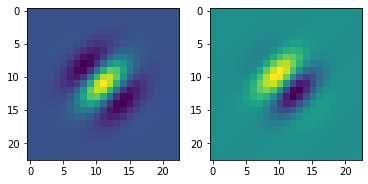

In [197]:
G_even = gabor_filter_even(xv,yv, sigma, np.pi/4, f0x, 0.)
G_odd  = gabor_filter_odd(xv,yv,sigma,np.pi/4,f0x,0.)
fig = plt.figure()
plt.subplot(1, 2, 1), plt.imshow(G_even)
plt.subplot(1, 2, 2), plt.imshow(G_odd)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5d31d63198>,
 <matplotlib.image.AxesImage at 0x7f5d23a8f4e0>)

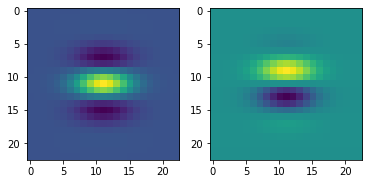

In [198]:
G_even = gabor_filter_even(xv,yv, sigma, np.pi/2, f0x, 0.)
G_odd  = gabor_filter_odd(xv,yv,sigma,np.pi/2,f0x,0.)
fig = plt.figure()
plt.subplot(1, 2, 1), plt.imshow(G_even)
plt.subplot(1, 2, 2), plt.imshow(G_odd)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5d2398be80>,
 <matplotlib.image.AxesImage at 0x7f5d23cb4ac8>)

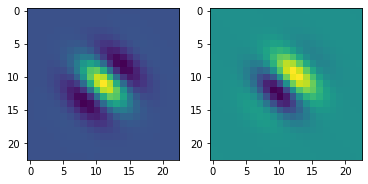

In [199]:
G_even = gabor_filter_even(xv,yv, sigma, np.pi/4*3, f0x, 0.)
G_odd  = gabor_filter_odd(xv,yv,sigma,np.pi/4*3,f0x,0.)
fig = plt.figure()
plt.subplot(1, 2, 1), plt.imshow(G_even)
plt.subplot(1, 2, 2), plt.imshow(G_odd)

In [200]:
space_time_kernel_1 = G_even[:,:,None]*Tbi
space_time_kernel_2 = G_odd[:,:,None]*Tmono
space_time_kernel_full = space_time_kernel_1 + space_time_kernel_2

np.save('space_time_kernel1.npy', space_time_kernel_1)
np.save('space_time_kernel2.npy', space_time_kernel_2)
np.save('space_time_kernel_combined.npy', space_time_kernel_full)

In [201]:
# Filter bank
angle = np.arange(0.,np.pi, np.pi/8)
print(angle)
num_orientations = len(angle)

filters = []
for an in angle:
    G_even = gabor_filter_even(xv,yv, sigma, an, f0x, 0.)
    G_odd  = gabor_filter_odd(xv,yv,sigma,an,f0x,0.)
    space_time_kernel = G_even[:,:,None]*Tbi + G_odd[:,:,None]*Tmono
    filters.append( space_time_kernel )

# size of each kernel
space_time_kernel.shape

[0.         0.39269908 0.78539816 1.17809725 1.57079633 1.96349541
 2.35619449 2.74889357]


(23, 23, 40)

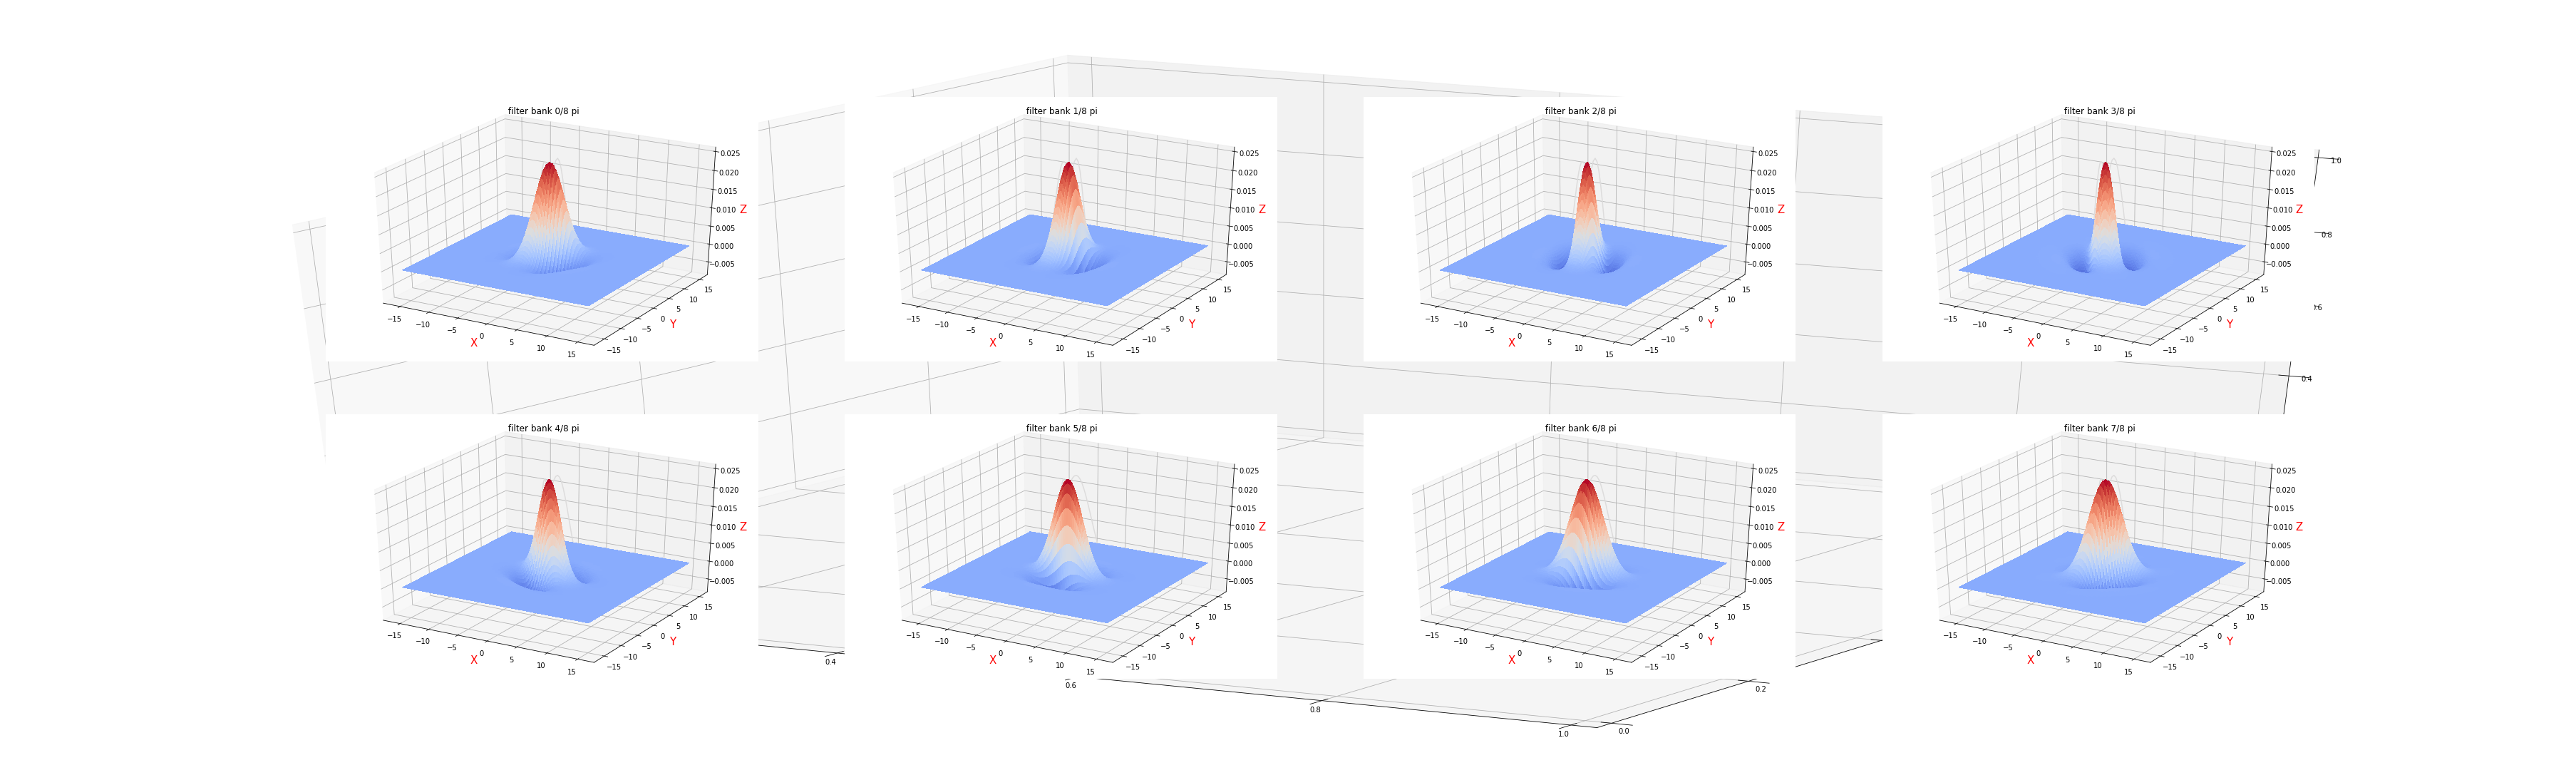

In [213]:
fig = plt.figure(figsize=(50,15))
ax = Axes3D(fig)
X = np.arange(-np.pi*5, np.pi*5, np.pi/10)
Y = np.arange(-np.pi*5, np.pi*5, np.pi/10)
R=np.arange(0,np.pi,np.pi/8)
X, Y = np.meshgrid(X, Y)
for i in range(len(filters)):
    Z=gabor_filter_even(X,Y,2.5,R[i],f0x,f0y)
    ax = fig.add_subplot(2, len(filters)/2, i+1, projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    # ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.25)
    cset = ax.contour(X, Y, Z, zdir='z', offset=-np.pi/4, cmap=cm.coolwarm)
    cset = ax.contour(X, Y, Z, zdir='x', offset=-np.pi/4, cmap=cm.coolwarm)
    cset = ax.contour(X, Y, Z, zdir='y', offset=3*np.pi/4, cmap=cm.coolwarm)
    # cb = fig.colorbar(p, shrink=0.5)
    ax.set_title(" filter bank "+str(i)+"/8 pi")
    ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
    ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
    ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})

In [203]:
num_bins_t = space_time_kernel_1.shape[2]
print(num_bins_t)

40


(Text(0.5, 0, 'x pixel'),
 Text(0, 0.5, 'time bin'),
 Text(0.5, 1.0, 'Combined filter'))

<Figure size 432x288 with 0 Axes>

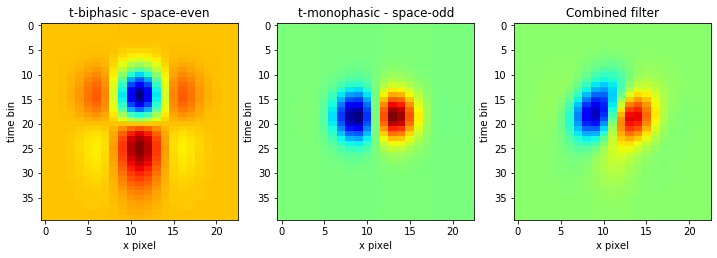

In [204]:
# Plot an x-t slice of each component of the space-time filter
# Fig 3 in the 2014 paper

slice_idx = int(ksize/2)  # index of the central y-slice

max = np.max(space_time_kernel_full)
min = np.min(space_time_kernel_full)
fig = plt.figure()
plt.figure(figsize=(12,12))

plt.subplot(1, 3, 1),
plt.imshow(np.transpose(space_time_kernel_1[:,slice_idx,:]), cmap='jet_r')
#plt.gca().invert_yaxis()
plt.gca().set_aspect( (1. * ksize / num_bins_t) )
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("t-biphasic - space-even")

plt.subplot(1, 3, 2),
plt.imshow(np.transpose(space_time_kernel_2[:,slice_idx,:]), cmap='jet_r')
plt.gca().set_aspect( (1. * ksize / num_bins_t) )
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("t-monophasic - space-odd")

plt.subplot(1, 3, 3),
plt.imshow(np.transpose(space_time_kernel_full[:,slice_idx,:]), vmin=min, vmax=max, cmap='jet_r')
plt.gca().set_aspect( (1. * ksize / num_bins_t) )
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("Combined filter")



<Figure size 432x288 with 0 Axes>

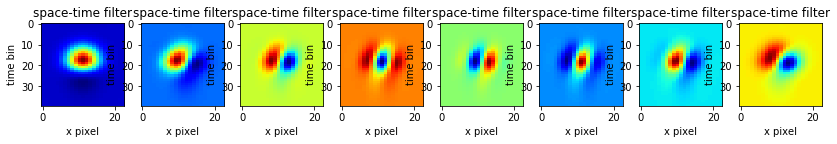

In [210]:
# Show filters
fig = plt.figure()
plt.figure(figsize=(14,14))
num_filters = len(filters)
# print(filters[0][:,5,:])
for i in range(len(filters)):
    plt.subplot(1,num_filters, i+1),
    #plt.imshow(np.transpose(filters[i][:,slice_idx,:]), cmap='jet_r')
    plt.imshow(np.transpose(filters[i][:,5,:]), cmap='jet_r')
    #plt.gca().invert_yaxis()
    plt.gca().set_aspect( (1. * ksize / num_bins_t) )
    plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("space-time filter")



In [170]:
# Compute response of the filter to a given input. See description in LNAI8774 2014
# Bio-inspired optic flow from event-based neuromorphic sensor input, Section 3

In [171]:
# Get a subset of events
i_offset = 2000000
num_events = 80000

ev_subset = []
# print("event_lit=",event_data.event_list)
with Timer("reading data"):
    for i,e in enumerate(event_data.event_list):
        if (i>=i_offset and i< i_offset+num_events):
            # print("event=",e.x,e.y,e.t,e.p)
            ev_subset.append([e.x,e.y,e.t,e.p])

ev_subset = np.array(np.array(ev_subset))
print(ev_subset.shape)

reading data: 0.32s
(80000, 4)


In [172]:
# Time span of the events
t_min = np.min(ev_subset[:,2])
t_max = np.max(ev_subset[:,2])
dt_span = t_max - t_min
print(dt_span) # [seconds]

num_bins_tev = int(np.ceil(dt_span / dt_res))
print( num_bins_tev ) # number of bins in which the events fit

0.13078500000000037
44


In [173]:
# First, try the synchronous solution: convert the events to a 3D voxel grid by voting:
# each events fills in some part of the 3D grid, according to a Gaussian weights in space and time

# DAVIS camera pixel resolution
sensor_width = 240
sensor_height = 180

# Select sub-region of the image
band_height = 40
band_width = 80
offset_height = 20
offset_width = 70

# 3D Meshgrid
x_ = range(0,band_width)
y_ = range(0,band_height)
z_ = range(0,num_bins_tev)
yv, xv, tv = np.meshgrid(y_,x_, z_, indexing='ij')
# Voting spread of each event
sigma_xy = 1.  # [pixels]
sigma_t =  1.0 # [time bins]

grid_vox = np.zeros((band_height,band_width,num_bins_tev),dtype=np.float32)
# t_begin = time.time()
with Timer("synchronous solution computing..."):
    for ie in range(0,num_events):
        # x,y,t coordinates in the voxel grid (could be non-integer)
        x = ev_subset[ie,0]
        y = ev_subset[ie,1]
        p=ev_subset[ie,3]
        if ((offset_height <= y) and (y < offset_height + band_height)
            and (offset_width <= x) and (x < offset_width + band_width)):
            x -= offset_width
            y -= offset_height
            t = ev_subset[ie,2]
            t_bin_coord = (t - t_min)/dt_res
            assert t_bin_coord >= 0, "must non-negative"
            assert t_bin_coord <= num_bins_tev, "must be smaller than the number of bins"

            # Brute-force voting: using xv,yv,tv in spite of them having many zeros for each event
            exponent_space = -((xv-x)**2 + (yv-y)**2) / (2*(sigma_xy**2))  # units: pixel^2 / pixel^2
            exponent_time = -((tv-t_bin_coord)**2) / (2*(sigma_t**2))      # units: bin^2 / bin^2
            grid_vox += np.exp( exponent_space + exponent_time )

# print (np.round_(time.time() - t_begin, 3), 'sec elapsed')
print(grid_vox.shape)
# print(grid_vox)
# plt.imshow(grid_vox)

synchronous solution computing...: 15.65s
(40, 80, 44)


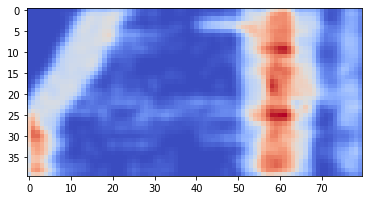

In [174]:
res = np.sum(grid_vox,axis=2)
plt.imshow(res, cmap=cm.coolwarm)
np.save('input_data.npy', grid_vox)
# python scripts/visualize_dsi_volume.py -i input_data.npy

In [175]:
for i in range(len(filters)):
    filename = 'kernel' + str(i) + '.npy'
    np.save(filename, filters[i])
    # python scripts/visualize_dsi_volume.py -i file.npy

In [176]:
# 3D convolution with filter bank
print(len(filters))
outs = []
with Timer("convolustion..."):
    for filt in filters:
        out = signal.convolve( grid_vox, filt, mode='same')
        outs.append(out)

8
convolustion...: 0.17s


<Figure size 432x288 with 0 Axes>

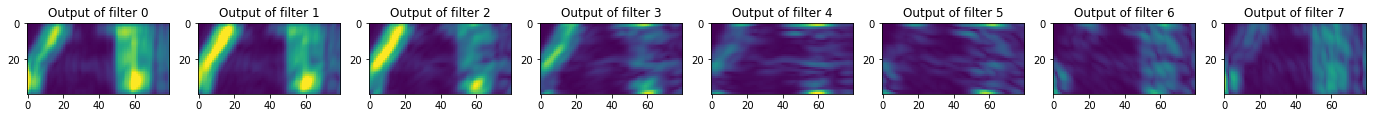

In [177]:
# Visualize results
fig = plt.figure()
plt.figure(figsize=(24,24))

max = 0
out_xy = []
for i in range(len(outs)):
    out_ = np.sum(np.abs(outs[i]),2)
    max = np.max([max, np.max(out_)])
    out_xy.append(out_)

for i in range(len(outs)):
    plt.subplot(1, len(outs), i+1)
    plt.imshow(out_xy[i], vmax=0.8*max, vmin=0)
    plt.title('Output of filter ' + str(i))

In [178]:
u=np.zeros((band_height,band_width),dtype=np.float32)
v=np.zeros((band_height,band_width),dtype=np.float32)
N=4
with Timer("Aggregate..."):
    for k in range(len(filters)):
        u=u+np.cos(np.pi*2*k/N)*out_xy[k]
        v=v+(-1)*np.sin(np.pi*2*k/N)*out_xy[k]
print("u=",u.shape)
print("v=",v.shape)

Aggregate...: 0.00s
u= (40, 80)
v= (40, 80)


(40, 80)


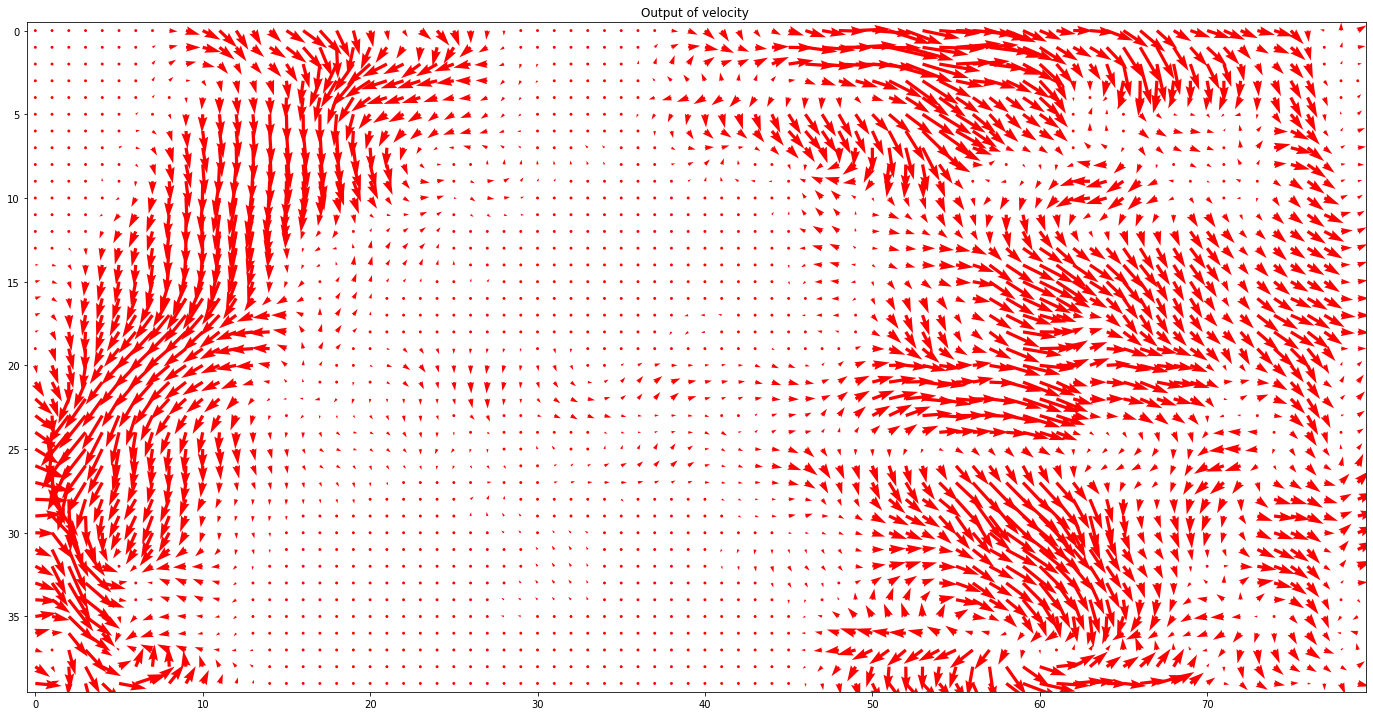

In [179]:
fig=plt.figure(figsize=(24,18))
image=np.zeros((band_height,band_width))
print(image.shape)
plt.imshow(image,cmap='binary')
X,Y=np.meshgrid(np.arange(0,band_width),np.arange(0,band_height))
plt.quiver(X,Y,u,v,color='r')
# for x_ in range(band_width):
#     for y_ in range(band_height):
#         plt.quiver(y_,x_,u[y_,x_],v[y_,x_],color='black',width=0.001,minlength=0.05)
plt.title('Output of velocity ')
plt.show()

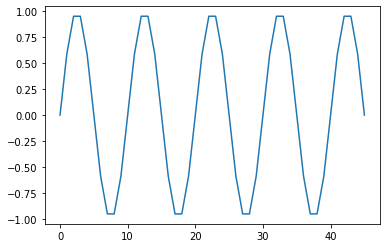

In [180]:
Nx_dft = 2*ksize
kx = np.arange(-Nx_dft/2, Nx_dft/2)*2./Nx_dft
x = np.arange(0,Nx_dft) # pixels
f0 = 0.1 # cycles / pix
z = np.sin(2*np.pi*f0*x)
plt.plot(x, z)

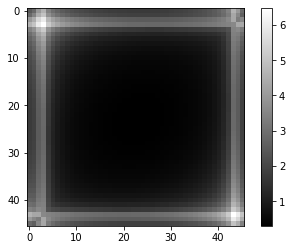

In [181]:
# Fourier design
x_ = range(0,Nx_dft)
xv, yv = np.meshgrid(x_,x_)
f0x = 0.057 # cycles / pix
f0y = 0.057 # cycles / pix
z = np.sin(2*np.pi*(f0x*xv+f0y*yv))
Z = np.fft.fft2(z)
plt.imshow(np.log(1.+np.abs(Z)), cmap='gray')
plt.colorbar()

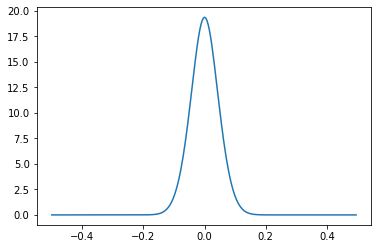

In [182]:
Nt_dft = 256
F_tmono = np.fft.fft(Tmono,Nt_dft)
F_tbi = np.fft.fft(Tbi,Nt_dft)
kt = ft_nyquist * np.arange(-Nt_dft/2, Nt_dft/2)/Nt_dft
plt.plot(kt, np.abs(np.fft.fftshift(F_tmono)))

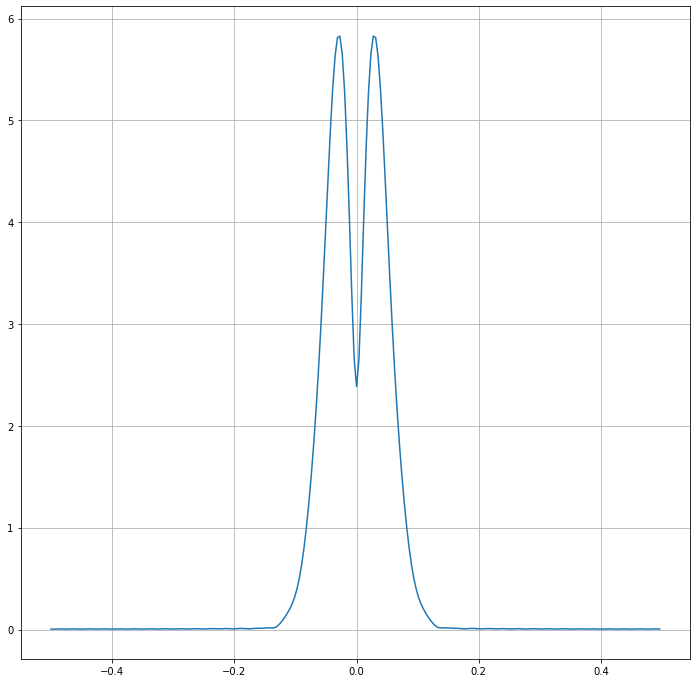

In [183]:
plt.figure(figsize=(12,12))
plt.plot(kt, np.abs(np.fft.fftshift(F_tbi)))
freq = np.fft.fftfreq(Nt_dft, d=dt_res)
plt.grid()
#kt = np.fft.fftshift(freq)

In [184]:
idx = np.argmax(np.abs(np.fft.fftshift(F_tbi)))
print(idx)
print(kt[idx])

121
-0.02734375


In [185]:
f0x_should_be = 9.11 / 90
print(f0x_should_be)





0.10122222222222221
